# Prerequisite
You need to have a working local installation of Ansys

## Sections
### I. Transmon only
1. Prepare the layout in qiskit-metal. <br>
1. Run finite element eigenmode analysis. <br>
1. Plot fields and display them. <br>
1. Set up EPR junction dictionary. <br>
1. Run EPR analysis on single mode. <br>
1. Get qubit freq and anharmonicity. <br>
1. Calculate EPR of substrate.  <br>
1. (Extra: Calculate surface EPR.) <br>

### II. Resonator only
1. Update the layout in qiskit-metal. <br>
1. Run finite element eigenmode analysis. <br>
1. Plot fields and display them. <br>
1. Calculate EPR of substrate. <br>
    
### III. Transmon & resonator
1. Update the layout in qiskit-metal. <br>
1. Run finite element eigenmode analysis. <br>
1. Plot fields and display them. <br>
1. Set up EPR junction dictionary. <br>
1. Run EPR analysis on the two modes. <br>
1. Get qubit frequency and anharmonicity. <br>

### IV. Analyze a coupled 2 transmon system. 
1. Finite Element Eigenmode Analysis
1. Identify the mode you want. The mode can inclusively be from 1 to setup.n_modes.
1. Set variables in the Ansys design. As before, we seek 2 modes.
1. Set up the simulation and specify the variables for the sweep.
1. Plot the E-field on the chip's surface.
1. Specify the junctions in the model; in this case there are 2 junctions.
1. Find the electric and magnetic energy stored in the substrate and the system as a whole.
1. Perform EPR analysis for all modes and variations.

In [1]:
%reload_ext autoreload
%autoreload 2

import qiskit_metal as metal
from qiskit_metal import designs, draw
from qiskit_metal import MetalGUI, Dict, Headings
import pyEPR as epr

# 1. Analyze the transmon qubit by itself

We will use the analysis package - applicable to most users. Advanced users might want to expand the package, or directly interact with the renderer. The renderer is one of the properties of the analysis class.

### Create the Qbit design

Setup a design of a given dimension. Dimensions will be respected in the design rendering. <br>
Note that the design size extends from the origin into the first quadrant.

In [2]:
design = designs.DesignPlanar({}, True)
design.chips.main.size['size_x'] = '2mm'
design.chips.main.size['size_y'] = '2mm'

gui = MetalGUI(design)

Create a single transmon with one readout resonator and move it to the center of the chip previously defined.

In [3]:
from qiskit_metal.qlibrary.qubits.transmon_pocket import TransmonPocket

design.delete_all_components()

q1 = TransmonPocket(design, 'Q1', options = dict(
    pad_width = '425 um', 
    pocket_height = '650um',
    connection_pads=dict(
        readout = dict(loc_W=+1,loc_H=+1, pad_width='200um')
    )))

gui.rebuild()
gui.autoscale()

### Finite Element Eigenmode Analysis

#### Setup

Select the analysis you intend to run from the `qiskit_metal.analyses` collection.<br>
Select the design to analyze and the tool to use for any external simulation

In [4]:
from qiskit_metal.analyses.quantization import EigenmodeAndEPR
eig1 = EigenmodeAndEPR(design, "hfss")

Review and update the convergence parameters and junction properties by executing following two cells.

In [5]:
eig1.setup

{'name': 'Setup',
 'min_freq_ghz': 1,
 'n_modes': 1,
 'max_delta_f': 0.5,
 'max_passes': 10,
 'min_passes': 1,
 'min_converged': 1,
 'pct_refinement': 30,
 'basis_order': -1,
 'Lj': '10 nH',
 'Cj': '0 fF'}

In [6]:
eig1.setup.max_passes = 6   # update single setting
eig1.setup_update(Lj = '11 nH', max_delta_f = 0.1)   # update multiple settings
eig1.setup

{'name': 'Setup',
 'min_freq_ghz': 1,
 'n_modes': 1,
 'max_delta_f': 0.1,
 'max_passes': 6,
 'min_passes': 1,
 'min_converged': 1,
 'pct_refinement': 30,
 'basis_order': -1,
 'Lj': '11 nH',
 'Cj': '0 fF'}

#### Execute. Then verify convergence and EM field
Analyze a single qubit with shorted terminations. Then observe the frequency convergence plot. If not converging, you might want to increase the min_passes value to force the renderer to increase accuracy

In [7]:
eig1.run(components=['Q1'], open_terminations=[], box_plus_buffer = False)
eig1.plot_convergences()

INFO 08:33PM [connect_project]: Connecting to Ansys Desktop API...
INFO 08:33PM [load_ansys_project]: 	Opened Ansys App
INFO 08:33PM [load_ansys_project]: 	Opened Ansys Desktop v2020.2.0
INFO 08:33PM [load_ansys_project]: 	Opened Ansys Project
	Folder:    C:/Users/MarcoFacchini/Documents/Ansoft/
	Project:   Project2
INFO 08:33PM [connect_design]: 	Opened active design
	Design:    TransmonQubit4 [Solution type: Eigenmode]
INFO 08:33PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 08:33PM [connect]: 	Connected to project "Project2" and design "TransmonQubit4" 😀 

INFO 08:33PM [connect_design]: 	Opened active design
	Design:    Design_hfss7 [Solution type: Eigenmode]
WARNING 08:33PM [connect_setup]: 	No design setup detected.
WARNING 08:33PM [connect_setup]: 	Creating eigenmode default setup.
INFO 08:33PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 08:34PM [get_setup]: 	Opened setup `Setup1`  (<class 'pyEPR.ansys.HfssEMSetup'

(optional) Captures the renderer GUI

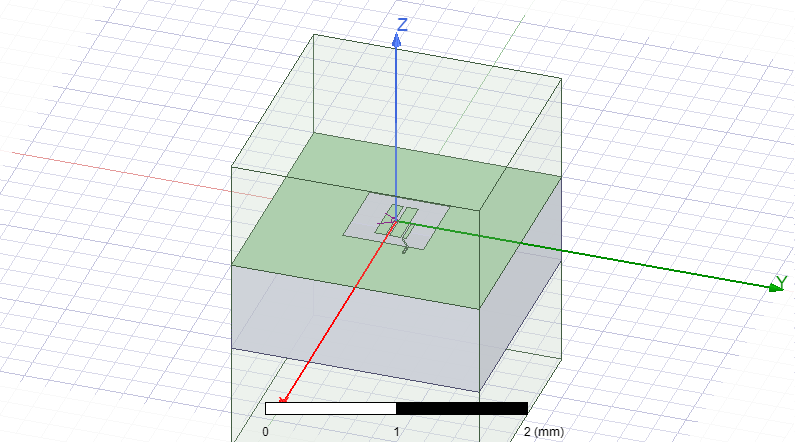

WindowsPath('C:/Users/MarcoFacchini/Documents/GitHub/qiskit-metal-public/tutorials/6 Analysis/ansys.png')

In [8]:
eig1.save_screenshot()

In [9]:
#
# TODO.....what is this????
#
eig1.recompute_convergences("scale_factor='100.2001'")

08:34PM 44s INFO [get_f_convergence]: Saved convergences to C:\Users\MarcoFacchini\Documents\GitHub\qiskit-metal-public\tutorials\6 Analysis\hfss_eig_f_convergence.csv


(optional) Work directly with the convergence numbers

In [10]:
eig1.convergence_f

,re(Mode(1)) [g]
Pass [],
1,3.217969
2,5.779274
3,6.037111
4,6.163491
5,6.240856
6,6.281301


(optional) You can re-run the analysis after varying the parameters.<br>
Not passing the parameter `components` to the run() method, skips the rendering and tries to run the analysis on the latest design. If a design is not found, the full metal design is rendered.

In [ ]:
eig1.setup.min_freq_ghz = 4
eig1.run()
eig1.convergence_f

Verify that the Electro(magnetic) fields look realistic.

In [ ]:
eig1.plot_fields('main')
eig1.save_screenshot()

(optional) clear the renderer by removing the fields

In [ ]:
eig1.clear_fields()

### EPR Analysis
#### Setup

Identify the non-linear (Josephson) junctions in the model. In this case there's only one, namely 'jj'. Also define the dissipative reference shapes.

In [11]:
eig1.add_junction(name='jj', rect='JJ_rect_Lj_Q1_rect_jj', line='JJ_Lj_Q1_rect_jj_',
                  Lj_variable='Lj', Cj_variable='Cj')
eig1.add_dissipative(category='dielectrics_bulk', name_list=['main'])

Initialize epr package

In [12]:
eig1.epr_start()

Design "Design_hfss7" info:
	# eigenmodes    1
	# variations    1


Inspect the electric and magnetic energy stored in the substrate and the system as a whole.

In [13]:
eig1.epr_get_stored_energy()


        ℰ_elec_all       = 4.44130299783164e-24
        ℰ_elec_substrate = 4.08650591816911e-24
        EPR of substrate = 92.0%

        ℰ_mag    = 2.24862129161893e-26
        


#### Execute EPR for all modes/variations. Then verify spectrum analysis and Hamiltonian

In [14]:
eig1.epr_run_analysis()


Variation 0  [1/1]
variables _Cj     0fF
_Lj    11nH
dtype: object
jj    1.100000e-08
dtype: float64 jj    2.000000e-15
dtype: float64

  Mode 0 at 6.28 GHz   [1/1]
    Calculating ℰ_magnetic,ℰ_electric
       (ℰ_E-ℰ_H)/ℰ_E       ℰ_E       ℰ_H
               99.5%  2.221e-24 1.124e-26

    Calculating junction energy participation ration (EPR)
	method=`line_voltage`. First estimates:
	junction        EPR p_0j   sign s_0j    (p_capacitive)
0 JJ_Lj_Q1_rect_jj_ 1.1000000000000003e-08 2e-15
39466577871.08708 2e-15 1.1000000000000003e-08 8.29492802834162e-06 434.132356581958 6281300955.10472
		Energy fraction (Lj over Lj&Cj)= 96.69%
	jj              0.904197  (+)        0.0309845
		(U_tot_cap-U_tot_ind)/mean=6.27%
Calculating Qdielectric_main for mode 0 (0/0)
p_dielectric_main_0 = 0.92011419175054

ANALYSIS DONE. Data saved to:

C:\data-pyEPR\Project2\Design_hfss7\2021-04-20 20-35-00.npz




Perform Hamiltonian spectrum post-analysis, building on mw solutions using EPR

In [15]:
eig1.epr_spectrum_analysis(cos_trunc = 8, fock_trunc = 7)

WARNING 08:35PM [__init__]: <p>Error: <class 'IndexError'></p>


	 Differences in variations:



 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Variation 0

Starting the diagonalization
Finished the diagonalization
Pm_norm=
modes
0    1.13427
dtype: float64

Pm_norm idx =
     jj
0  True
*** P (participation matrix, not normlz.)
         jj
0  0.877023

*** S (sign-bit matrix)
   s_jj
0     1
*** P (participation matrix, normalized.)
      0.99

*** Chi matrix O1 PT (MHz)
    Diag is anharmonicity, off diag is full cross-Kerr.
       328

*** Chi matrix ND (MHz) 
       369

*** Frequencies O1 PT (MHz)
0    5952.872002
dtype: float64

*** Frequencies ND (MHz)
0    5933.425545
dtype: float64

*** Q_coupling
Empty DataFrame
Columns: []
Index: [0]


Report solved results

In [16]:
eig1.epr_report_hamiltonian(swp_variable = 'Lj')  # suppose we swept an optimetric analysis vs. inductance Lj_alice

#### Mode frequencies (MHz)

###### Numerical diagonalization

Lj,11
eigenmode,
0,5952.87


#### Kerr Non-linear coefficient table (MHz)

###### Numerical diagonalization

,,0
Lj,,
11,0,368.72


Release Ansys session

In [17]:
eig1.close()

# 2. Analyze the CPW resonator by itself
### Update the design in Metal

Connect the transmon to a CPW. <br>
The other end of the CPW connects to an open to ground termination.

In [18]:
from qiskit_metal.qlibrary.connectors.open_to_ground import OpenToGround
from qiskit_metal.qlibrary.interconnects.meandered import RouteMeander
otg = OpenToGround(design, 'open_to_ground', options=dict(pos_x='1.75mm',  pos_y='0um', orientation='0'))
RouteMeander(design, 'readout',  Dict(
        total_length='6 mm',
        fillet='90 um',
        lead = dict(start_straight='100um'),
        pin_inputs=Dict(
            start_pin=Dict(component='Q1', pin='readout'),
            end_pin=Dict(component='open_to_ground', pin='open')), ))

gui.rebuild()
gui.autoscale()

#### Render the resonator Design in Ansys
Connect again to Ansys. <br>
Then create and activate a separate eigenmode design called "Readout".

In [ ]:
hfss.connect_ansys()
hfss.activate_eigenmode_design("Readout")

Render the readout and an open to ground termination. <br>
Add open endcaps to both ends of the readout.

In [ ]:
hfss.render_design(['readout', 'open_to_ground'], [('readout', 'start'), ('readout', 'end')])
hfss.save_screenshot()

#### Prepare and run the analysis, then plot E-field

Set variables in the Ansys design.

In [ ]:
# Analysis properties
setup = hfss.pinfo.setup
setup.passes = 10
print(f"""
Number of eigenmodes to find             = {setup.n_modes}
Number of simulation passes              = {setup.passes}
Convergence freq max delta percent diff  = {setup.delta_f}
""")

pinfo = hfss.pinfo
pinfo.design.set_variable('Lj', '10 nH')
pinfo.design.set_variable('Cj', '0 fF')
setup.analyze()

hfss.plot_convergences()

Recover eigenmode frequencies for each variation.

In [ ]:
eprd = epr.DistributedAnalysis(hfss.pinfo)
eprd.get_ansys_frequencies_all()

Display the Ansys modeler window and plot the E-field on the chip's surface.

In [ ]:
hfss.modeler._modeler.ShowWindow()
hfss.plot_ansys_fields('main')
hfss.save_screenshot()

Delete the newly created E-field plot.

In [ ]:
hfss.plot_ansys_delete(['Mag_E1'])

#### Try again with a larger number of steps (better convergence)

Update the number of passes, analyze, and plot convergence data.

In [ ]:
setup.passes = 15
setup.analyze()
hfss.plot_convergences()

Display the Ansys modeler window again and plot the E-field on the chip's surface with this updated number of passes. <br>
Note that the bright areas have become much smoother compared to the previous image, indicating better convergence.

In [ ]:
hfss.modeler._modeler.ShowWindow()
hfss.plot_ansys_fields('main')
hfss.save_screenshot()

In [ ]:
%metal_print Part 2. Energy-Participation-Ratio Analysis

Find the electric and magnetic energy stored in the substrate and the system as a whole.

In [ ]:
ℰ_elec = eprd.calc_energy_electric()
ℰ_elec_substrate = eprd.calc_energy_electric(None, 'main')
ℰ_mag = eprd.calc_energy_magnetic()

print(f"""
ℰ_elec_all       = {ℰ_elec}
ℰ_elec_substrate = {ℰ_elec_substrate}
EPR of substrate = {ℰ_elec_substrate / ℰ_elec * 100 :.1f}%

ℰ_mag_all       = {ℰ_mag}
ℰ_mag % of ℰ_elec_all  = {ℰ_mag / ℰ_elec * 100 :.1f}%
""")

Release Ansys session

In [ ]:
hfss.disconnect_ansys()

In [ ]:
%metal_heading Tutorial 3: Analyze the combined transmon + CPW resonator system. 

In [ ]:
%metal_print Part 1. Finite Element Eigenmode Analysis

Connect to Ansys, then create and activate an eigenmode Ansys design called "TransmonResonator".

In [ ]:
hfss.connect_ansys()
hfss.activate_eigenmode_design("TransmonResonator")

Render everything in the Metal design, including both the transmon and the readout. <br>
Add an open endcap to the readout.

In [ ]:
hfss.render_design(['Q1', 'readout', 'open_to_ground'], [('readout', 'end')])
hfss.save_screenshot()

Set variables in the Ansys design. Note that this time we seek 2 eigenmodes - one with stronger fields near the transmon, the other with stronger fields near the resonator.

In [ ]:
# Analysis properties
setup = hfss.pinfo.setup
setup.n_modes = 2
setup.passes = 10
print(f"""
Number of eigenmodes to find             = {setup.n_modes}
Number of simulation passes              = {setup.passes}
Convergence freq max delta percent diff  = {setup.delta_f}
""")

pinfo = hfss.pinfo
pinfo.design.set_variable('Lj', '10 nH')
pinfo.design.set_variable('Cj', '0 fF')
setup.analyze()

hfss.plot_convergences()

Display the Ansys modeler window again and plot the E-field on the chip's surface.

In [ ]:
hfss.modeler._modeler.ShowWindow()
hfss.plot_ansys_fields('main')
hfss.save_screenshot()

Delete the newly created E-field plot.

In [ ]:
hfss.plot_ansys_delete(['Mag_E1'])

In [ ]:
%metal_print Part 2. Energy-Participation-Ratio Analysis

Specify the junctions in the model; in this case there's only one, namely 'jj'.

In [ ]:
#Non-linear (Josephson) junction
pinfo = hfss.pinfo 
pinfo.junctions['jj'] = {'Lj_variable': 'Lj',  'rect': 'JJ_rect_Lj_Q1_rect_jj', 
                             'line': 'JJ_Lj_Q1_rect_jj_',  'Cj_variable': 'Cj'}
pinfo.validate_junction_info() # Check that valid names of variables and objects have been supplied
pinfo.dissipative['dielectrics_bulk'] = ['main'] # Dissipative elements: specify
# Handles  microwave analysis on eigenmode solutions
eprd = epr.DistributedAnalysis(pinfo)

In [ ]:
eprd = epr.DistributedAnalysis(pinfo)
eprd.set_mode(1)

Find the electric and magnetic energy stored in the substrate and the system as a whole.

In [ ]:
ℰ_elec = eprd.calc_energy_electric()
ℰ_elec_substrate = eprd.calc_energy_electric(None, 'main')
ℰ_mag = eprd.calc_energy_magnetic()

print(f"""
ℰ_elec_all       = {ℰ_elec}
ℰ_elec_substrate = {ℰ_elec_substrate}
EPR of substrate = {ℰ_elec_substrate / ℰ_elec * 100 :.1f}%

ℰ_mag_all       = {ℰ_mag}
ℰ_mag % of ℰ_elec_all  = {ℰ_mag / ℰ_elec * 100 :.1f}%
""")

In [ ]:
eprd.set_mode(0)

Perform EPR analysis for all modes and variations.

In [ ]:
eprd.do_EPR_analysis()

# 4a. Perform Hamiltonian spectrum post-analysis, building on mw solutions using EPR
epra = epr.QuantumAnalysis(eprd.data_filename)
epra.analyze_all_variations(cos_trunc = 8, fock_trunc = 7)

# 4b. Report solved results
swp_variable = 'Lj' # suppose we swept an optimetric analysis vs. inductance Lj_alice
epra.plot_hamiltonian_results(swp_variable=swp_variable)
epra.report_results(swp_variable=swp_variable, numeric=True)

Release Ansys's session

In [ ]:
hfss.disconnect_ansys()

In [ ]:
%metal_heading Tutorial 4: Analyze a coupled 2 transmon system. 

In [ ]:
%metal_print Part 1. Finite Element Eigenmode Analysis

Connect to Ansys, then create and activate an eigenmode Ansys design called "TransmonResonator".

In [ ]:
hfss.connect_ansys()

In [ ]:
hfss.activate_eigenmode_design("TwoTransmon")

Create a Metal design consisting of 2 transmons connected by a short coupler.

In [ ]:
from qiskit_metal.qlibrary.qubits.transmon_pocket import TransmonPocket
from qiskit_metal.qlibrary.interconnects.straight_path import RouteStraight

design.delete_all_components()

q1 = TransmonPocket(design, 'Q1', options = dict(
    pad_width = '425 um', 
    pocket_height = '650um',
    connection_pads=dict(
        readout = dict(loc_W=+1,loc_H=+1, pad_width='200um')
    )))

q2 = TransmonPocket(design, 'Q2', options = dict(
    pos_x = '1.0 mm',
    pad_width = '425 um', 
    pocket_height = '650um',
    connection_pads=dict(
        readout = dict(loc_W=-1,loc_H=+1, pad_width='200um')
    )))

coupler = RouteStraight(design, 'coupler', Dict(
        pin_inputs=Dict(
            start_pin=Dict(component='Q1', pin='readout'),
            end_pin=Dict(component='Q2', pin='readout')), ))

gui.rebuild()
gui.autoscale()

In [ ]:
hfss.options['x_buffer_width_mm'] = 0.5
hfss.options['y_buffer_width_mm'] = 0.5
hfss.options

In [ ]:
qcomps = design.components
qcomps['Q1'].options['hfss_inductance'] = 'Lj1'
qcomps['Q1'].options['hfss_capacitance'] = 'Cj1'
qcomps['Q2'].options['hfss_inductance'] = 'Lj2'
qcomps['Q2'].options['hfss_capacitance'] = 'Cj2'
gui.rebuild()

In [ ]:
design.qgeometry.tables['junction']

Identify the mode you want. The mode can inclusively be from 1 to setup.n_modes.

In [ ]:
hfss.set_mode(1, "Setup")

Set variables in the Ansys design. As before, we seek 2 modes.

In [ ]:
hfss.render_design(['coupler', 'Q1', 'Q2'], [])
hfss.save_screenshot()

Set up the simulation and specify the variables for the sweep.

In [ ]:
setup = hfss.pinfo.setup
setup.passes = 15
setup.delta_f = 0.05
setup.n_modes = 2

pinfo = hfss.pinfo
pinfo.design.set_variable('Lj1', '13 nH')
pinfo.design.set_variable('Cj1', '0 fF')
pinfo.design.set_variable('Lj2', '9 nH')
pinfo.design.set_variable('Cj2', '0 fF')

pinfo.setup.analyze()

hfss.plot_convergences()

Display the Ansys modeler window again and plot the E-field on the chip's surface.

In [ ]:
hfss.modeler._modeler.ShowWindow()
hfss.plot_ansys_fields('main')
hfss.save_screenshot()

Delete the newly created E-field plot.

In [ ]:
hfss.plot_ansys_delete(['Mag_E1'])

In [ ]:
%metal_print Part 2. Energy-Participation-Ratio Analysis

Specify the junctions in the model; in this case there are 2 junctions, namely 'jj' and 'jj2'.

In [ ]:
#Non-linear (Josephson) junction
pinfo.junctions['jj1'] = {'Lj_variable': 'Lj1',  'rect': 'JJ_rect_Lj_Q1_rect_jj', 
                             'line': 'JJ_Lj_Q1_rect_jj_',  'Cj_variable': 'Cj1'}
pinfo.junctions['jj2'] = {'Lj_variable': 'Lj2',  'rect': 'JJ_rect_Lj_Q2_rect_jj', 
                             'line': 'JJ_Lj_Q2_rect_jj_',  'Cj_variable': 'Cj2'}
pinfo.validate_junction_info() # Check that valid names of variables and objects have been supplied
pinfo.dissipative['dielectrics_bulk'] = ['main'] # Dissipative elements: specify
# Handles  microwave analysis on eigenmode solutions
eprd = epr.DistributedAnalysis(pinfo)

Find the electric and magnetic energy stored in the substrate and the system as a whole.

In [ ]:
ℰ_elec = eprd.calc_energy_electric()
ℰ_elec_substrate = eprd.calc_energy_electric(None, 'main')
ℰ_mag = eprd.calc_energy_magnetic()

print(f"""
ℰ_elec_all       = {ℰ_elec}
ℰ_elec_substrate = {ℰ_elec_substrate}
EPR of substrate = {ℰ_elec_substrate / ℰ_elec * 100 :.1f}%

ℰ_mag_all       = {ℰ_mag}
ℰ_mag % of ℰ_elec_all  = {ℰ_mag / ℰ_elec * 100 :.1f}%
""")

Perform EPR analysis for all modes and variations.

In [ ]:
eprd.do_EPR_analysis()

# 4a. Perform Hamiltonian spectrum post-analysis, building on mw solutions using EPR
epra = epr.QuantumAnalysis(eprd.data_filename)
epra.analyze_all_variations(cos_trunc = 8, fock_trunc = 7)

# 4b. Report solved results
swp_variable = 'Lj1' # suppose we swept an optimetric analysis vs. inductance Lj_alice
epra.plot_hamiltonian_results(swp_variable=swp_variable)
epra.report_results(swp_variable=swp_variable, numeric=True)

In [ ]:
for lj in range(12,16, 1):
    pinfo.design.set_variable('Lj1', f'{lj} nH')
    pinfo.setup.analyze()

Release Ansys's session

In [ ]:
hfss.disconnect_ansys()

In [ ]:
gui.main_window.close()